# MLNT - Food-101

Implemention of MLNT over the Food-101 dataset

- 1. Google Colab Settings
- 2. MLNT
- 3. Manage relabel log file

The main difference with respect to the food implementation is that the dataloader has been modified in order to be able to record how the relabeling is done on each batch.

## 1. Google Colab Settings:

In [1]:
!pip install wandb

     |████████████████████████████████| 1.4MB 2.8MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 112kB 17.7MB/s 
     |████████████████████████████████| 163kB 17.4MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=c74f448c42a4ce0a5d05f45c217d16757d2bc37585bc2cbed679fe335d0433dd
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.3-cp36-none-any.whl size=73870 sha256=1e0b8a8d4e0e7a70e0a019516c926129ae45ef78cf4919c7fd7c3fcebf736009
  Stored in directory: /root/.cache/pip/wheels/a8/1d/38/2c19bb311f67cc7b4d07a2ec5ea36ab1a0a0ea50db994a5bc7
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=ad03

In [2]:
!wandb login

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [3]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jul 24 09:02:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [5]:
import sys
sys.path.append('/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101')

## 2. MLNT 

In [6]:
# Pytorch libraries
import torch
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

# Internal files
import config
import dataloader
import models
# from baseline import get_model, save_checkpoint

import math
import pandas
import os
import sys
import time
from collections import OrderedDict
import random

import wandb
import pandas
import numpy as np


noise file /content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/noisy_label_kv30_sim.txt generated with noise: 0.3



In [7]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model



def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

In [8]:
def scheduler(epoch: int):
    global lr
    lr = config.lr
    if epoch > config.start_epoch:
        lr = lr / 10.0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training
def train(epoch):
    global init
    global df_relabel
    global df_dist
    net.train()
    tch_net.train()
    train_loss = 0
    correct = 0
    total = 0
    scheduler(epoch)


    # ramp up meta-learning rate and EMA decay
    if epoch <= config.param_epoch:
        u = epoch/config.param_epoch
        meta_lr = config.meta_lr*math.exp(-5*(1-u)**2)
        lamb = 0.5*math.exp(-5*(1-u)**2)
    else:
        meta_lr = config.meta_lr
        config.eps = 0.999

    for step, (inputs, targets, path) in enumerate(train_loader):
        # print(step, inputs, targets, path)
        init_time = time.time()
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)

        class_loss = criterion(outputs, targets)
        class_loss.backward(retain_graph=True)


        if step > config.start_iter or epoch > 1:
        #if step > 0 or epoch > 0:

            # if step > config.mid_iter or epoch > 1:
            #     # config.eps = 0.999
            #     alpha = config.alpha
            # else:
            #     u = (step - config.start_iter)/(config.mid_iter - config.start_iter)
            #     alpha = config.alpha*math.exp(-5*(1-u)**2)
            alpha = config.alpha

            if init:
                init = False
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.copy_(param.data)
            else:
                for param, param_tch in zip(net.parameters(), tch_net.parameters()):
                    param_tch.data.mul_(config.eps).add_((1-config.eps), param.data)

            _, feats = pretrain_net(inputs, get_feat=True)
            tch_outputs = tch_net(inputs, get_feat=False)
            p_tch = F.softmax(tch_outputs, dim=1)
            p_tch.detach_()

            if use_mentor == True:
                mnt_outputs = mentor_net(inputs, get_feat=False)
                p_mnt = F.softmax(tch_outputs, dim=1)
                p_mnt.detach_()

            for i in range(config.num_fast):
                targets_fast = targets.clone()
                targets_fast2 = targets.clone()
                distances = []
                randidx = torch.randperm(targets.size(0))
                for n in range(int(targets.size(0)*config.perturb_ratio)):
                    num_neighbor = 1
                    idx = randidx[n]
                    feat = feats[idx]
                    feat.view(1, feat.size(0))
                    feat.data = feat.data.expand(targets.size(0), feat.size(0))
                    dist = torch.sum((feat-feats)**2, dim=1)
                    darray = dist.cpu().numpy()
                    distances.append(np.amin(darray[darray!=0.]))
                    _, neighbor = torch.topk(dist.data, num_neighbor+1, largest=False)
                    targets_fast[idx] = targets[neighbor[random.randint(1, num_neighbor)]]
                    targets_fast2[idx] = -1 #mark the incdices that have been relabeled

                #set a row of the dataframe
                # print(distances)
                
                new_row = {"batch":step, "fast_num":i, "dir":path,"noisy_labels":targets, "knn_labels":targets_fast, "resample_index":targets_fast2, "dist":distances}
                # print(new_row)
                df_relabel = df_relabel.append(new_row,ignore_index=True)
                # new_row = {"dist": distances}
                # df_dist = df_dist.append(new_row, ignore_index = True)


                # #xexport relabel track dataframe
                # filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'.csv'
                # df_relabel.to_csv(filename, sep=';', index=False,header = False)
                # filename = config.drive_dir + '/data/' + 'relabeling_distances_'+str(int(config.r*100))+'.csv'      
                # df_dist.to_csv(filename, sep=';', index=False,header = False)


                fast_loss = criterion(outputs, targets_fast)

                grads = torch.autograd.grad(fast_loss, net.parameters(),
                                            create_graph=False,
                                            retain_graph=True,
                                            only_inputs=True)

                fast_weights = OrderedDict(
                    (name, param - meta_lr*grad)
                    for ((name, param), grad) in zip(net.named_parameters(), grads))

                fast_out = net.forward(inputs,fast_weights)

                logp_fast = F.log_softmax(fast_out,dim=1)

                #afegir canvis per iterative aquí
                if use_mentor == False:
                    consistent_loss = consistent_criterion(logp_fast, p_tch)
                else:
                    consistent_loss = consistent_criterion(logp_fast, p_tch*lamb + p_mnt*(1-lamb))

                consistent_loss = consistent_loss*alpha/config.num_fast
                consistent_loss.backward()

        optimizer.step()

        # train_loss += class_loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab training results
        sys.stdout.write('\r')
        sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%, time: %.3f'
              %(epoch, config.num_epochs, step+1, (len(train_loader.dataset)//config.batch_size)+1, class_loss.data.item(), 100.*correct/total,time.time() - init_time))
        sys.stdout.flush()

        #xexport relabel track dataframe
        filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'.csv'
        df_relabel.to_csv(filename, sep=';', index=False,header = False)


def valid(epoch, network):
    global best_acc
    network.eval()
    # val_loss = 0
    correct = 0
    total = 0
    for step, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = network(inputs)
            loss = criterion(outputs, targets)

        # valid_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        # Grab validation results
        valid_acc = 100. * correct / total
      # valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, "
      #                 "lr: {:.6f}".format(epoch,
      #                                     config.num_epochs,
      #                                     loss.data.item(),
      #                                     valid_acc,
      #                                     lr))
        # Grab validation results
        valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, ""lr: {:.6f}".format(epoch,config.num_epochs,loss.data.item(),valid_acc,lr))
        record.write(valid_results + '\n')
        record.flush()



    # Save checkpoint when best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('| Saving Best Model ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '.pth.tar'
        save_checkpoint({
            'state_dict': network.state_dict(),
            'best_acc': best_acc,
        }, save_point)

    wandb.log({'epoch': epoch, 'accy_val' : best_acc })

    return valid_results


def test():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets, path) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)

In [9]:
def save_weights(epoch):
        print('| Saving Weights student ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)

        print('| Saving Weights teacher ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': tch_net.state_dict(), }, save_point)

In [10]:
# Checkpoint dir.
record = open(config.drive_dir + '/checkpoint/' + config.checkpoint + '_test.txt', 'w')
#ecord.write('noise_rate=%s\n' % config.noise_rate)
record.flush()

# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
random.seed(config.seed)
# torch.cuda.set_device(config.gpuid)
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
tch_net = get_model()
pretrain_net = get_model()
test_net = get_model()

print('| load pretrained net. from checkpoint...')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
pretrain_net.load_state_dict(checkpoint['state_dict'])

if use_cuda:
    net.cuda()
    tch_net.cuda()
    pretrain_net.cuda()
    test_net.cuda()
    cudnn.benchmark = True
pretrain_net.eval()

for param in tch_net.parameters():
    param.requires_grad = False
for param in pretrain_net.parameters():
    param.requires_grad = False

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()
consistent_criterion = torch.nn.KLDivLoss()

# Instantiate an optimizer to train the model
optimizer = torch.optim.SGD(
    net.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print('\nTraining model')
print('| Training Epochs = ' + str(config.num_epochs))
print('| Initial Learning Rate = ' + str(config.lr))
print('| Optimizer = ' + str(config.optimizer_type))




Model setup
| Building network: resnet50


/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:116: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight, mode='fan_out')
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:118: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.weight, 1)
/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/models/resnet.py:119: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0)
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



| load pretrained net. from checkpoint...

Training model
| Training Epochs = 5
| Initial Learning Rate = 0.008
| Optimizer = SGD


In [11]:
def get_accy(loader):
    test_net.eval()
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab results results
    test_acc = 100. * correct/total
    test_results = "| loss: {:.3f}, acc: {:.3f}".format(
        loss.data.item(), test_acc)

    print(test_results)

In [ ]:
#initialize dataframer
import pandas as pd
df_relabel = pd.DataFrame(columns = ["batch", "fast_num", "dir", "noisy_labels", "knn_labels", "resample_index"])
# df_dist = pd.DataFrame(columns = ["dist"])


#set mentor parameter on the train funciton
use_mentor = False
init = True
best_acc = 0
for epoch in range(1, 5): #compute only one epoch
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)

print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()

| Epoch [  1/  5] Iter[501/1066]		Loss: 3.0002 Acc@1: 47.128%, time: 0.320

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


| Epoch [  1/  5] Iter[679/1066]		Loss: 3.4107 Acc@1: 46.824%, time: 5.791

In [13]:
df_relabel

,batch,fast_num,dir,noisy_labels,knn_labels,resample_index,dist
0,501,0,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(14, device='cuda:0'), tensor(-1, devic...","[215.86633, 214.72217, 332.11096, 129.38707, 3..."
1,501,1,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(14, device='cuda:0'), tensor(86, devic...","[404.8478, 132.84566, 323.43915, 215.86633, 23..."
2,501,2,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(99, device='cuda:0'), tensor(86, devic...","[tensor(-1, device='cuda:0'), tensor(86, devic...","[240.81102, 236.0886, 595.7417, 126.567665, 39..."
3,501,3,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(99, device='cuda:0'), tensor(86, devic...","[tensor(-1, device='cuda:0'), tensor(86, devic...","[132.84566, 323.43915, 358.1612, 404.8478, 176..."
4,501,4,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(14, device='cuda:0'), tensor(86, devic...","[tensor(99, device='cuda:0'), tensor(86, devic...","[tensor(-1, device='cuda:0'), tensor(86, devic...","[268.33136, 232.89653, 248.18268, 595.7417, 12..."
...,...,...,...,...,...,...,...
5645,1065,5,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(13, device='cuda:0'), tensor(50, devic...","[tensor(45, device='cuda:0'), tensor(50, devic...","[tensor(-1, device='cuda:0'), tensor(50, devic...","[376.41815, 305.51453, 911.37195, 325.3536, 30..."
5646,1065,6,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(13, device='cuda:0'), tensor(50, devic...","[tensor(13, device='cuda:0'), tensor(50, devic...","[tensor(13, device='cuda:0'), tensor(50, devic...","[325.3536, 519.97394, 305.51453, 305.51453, 91..."
5647,1065,7,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(13, device='cuda:0'), tensor(50, devic...","[tensor(13, device='cuda:0'), tensor(98, devic...","[tensor(13, device='cuda:0'), tensor(-1, devic...","[325.3536, 911.37195, 329.84723, 313.4089, 305..."
5648,1065,8,(/content/drive/My Drive/Colab_Notebooks/git/P...,"[tensor(13, device='cuda:0'), tensor(50, devic...","[tensor(45, device='cuda:0'), tensor(98, devic...","[tensor(-1, device='cuda:0'), tensor(-1, devic...","[325.3536, 313.4089, 911.37195, 414.05597, 519..."


### 2.1 Continue the learning process
*Not always mandatory, only required when the cell below has crashed due to limited time of execution of a google colab session.*

Fill the last fully finished epoch:

In [14]:
EPOCH = 14

Reload weights

In [ ]:
print('Load Student')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_student_' + str(EPOCH) + '.pth.tar' )
net.load_state_dict(checkpoint['state_dict'])

print('Load Teacher')
checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.id + '_teacher_' + str(EPOCH) + '.pth.tar' )
tch_net.load_state_dict(checkpoint['state_dict'])

# print('Load Mentor')
# checkpoint = torch.load(config.drive_dir + '/checkpoint/MLNT.pth.tar')
# mentor_net.load_state_dict(checkpoint['state_dict'])

Get accuracies on each dataset (not mandatory, good practice)

In [ ]:
print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/MLNT_discarding.pth.tar')
mentor_net.load_state_dict(checkpoint['state_dict'])
print('\n Validation Accy:')
get_accy(valid_loader)
print('\n Test Accy:')
get_accy(test_loader)
print('\n Train Accy:')
get_accy(train_loader)

Continue the learning process on the given epoch

In [ ]:
init = False
best_acc = 0
use_mentor = False
for epoch in range(EPOCH, EPOCH + 11):
    train(epoch)
    # Student validation
    std_results = valid(epoch, net)
    record.write(std_results + '\n')
    print(std_results)
    # Teacher validation
    tch_results = valid(epoch, tch_net)
    record.write(tch_results + '\n')
    record.flush()
    print(tch_results)

    save_weights(epoch)

print('\nTesting model')
checkpoint = torch.load(config.drive_dir + '/checkpoint/%s.pth.tar' % config.id)
test_net.load_state_dict(checkpoint['state_dict'])
test()

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2247: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


| Epoch: 14/60, val_loss: 0.833, val_acc: 74.231, lr: 0.000800
| Epoch: 14/60, val_loss: 0.613, val_acc: 76.686, lr: 0.000800
| Epoch [ 15/ 60] Iter[2131/2131]		Loss: 0.6046 Acc@1: 84.260%, time: 1.563| Epoch: 15/60, val_loss: 0.781, val_acc: 72.053, lr: 0.000800
| Epoch: 15/60, val_loss: 0.452, val_acc: 76.977, lr: 0.000800
| Epoch [ 16/ 60] Iter[1874/2131]		Loss: 0.6332 Acc@1: 84.957%, time: 2.965

### 2.2 Discarding

## 3. Manage relabel log file

In [ ]:
df_relabel

,batch,fast_num,dir,noisy_labels,knn_labels,resample_index,dist


In [ ]:
config.r = 0

Read file (it has been generated doing train)

In [ ]:
filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'.csv'
df_learning = pandas.read_csv(filename, sep=';',header = None)
df_learning.columns = ["batch", "fast_num", "dir", "noisy_labels", "knn_labels", "resample_index","dist"]
df_learning

,batch,fast_num,dir,noisy_labels,knn_labels,resample_index,dist
0,501,0,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 66, 10, 4, 97, 60, 60, 81, 32...","tensor([14, 86, 66, 33, 4, 97, 38, 60, 4, 32...","tensor([14, -1, -1, -1, 4, 97, -1, 60, -1, 32...","[316.4546, 238.75777, 422.64935, 126.03598, 35..."
1,501,1,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 66, 10, 4, 97, 60, 60, 81, 32...","tensor([14, 86, 66, 33, 4, 97, 38, 60, 4, 21...","tensor([14, 86, 66, -1, 4, 97, -1, 60, -1, -1...","[377.59943, 116.151505, 320.86145, 316.4546, 2..."
2,501,2,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 66, 10, 4, 97, 60, 60, 81, 32...","tensor([37, 86, 66, 33, 4, 93, 38, 60, 81, 32...","tensor([-1, 86, -1, -1, 4, -1, -1, 60, 81, 32...","[299.81494, 236.6802, 545.20044, 139.9636, 337..."
3,501,3,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 66, 10, 4, 97, 60, 60, 81, 32...","tensor([37, 86, 66, 33, 4, 97, 38, 60, 81, 32...","tensor([-1, 86, 66, -1, 4, 97, -1, 60, 81, 32...","[116.151505, 320.86145, 329.29584, 377.59943, ..."
4,501,4,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([14, 86, 66, 10, 4, 97, 60, 60, 81, 32...","tensor([37, 86, 66, 33, 81, 93, 38, 9, 4, 21...","tensor([-1, 86, 66, -1, -1, -1, -1, -1, -1, -1...","[220.0882, 282.69006, 363.6641, 545.20044, 139..."
...,...,...,...,...,...,...,...
5195,1020,5,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([ 2, 59, 87, 78, 2, 22, 18, 3, 95, 63...","tensor([ 2, 59, 87, 78, 2, 47, 18, 3, 95, 55...","tensor([-1, -1, 87, 78, 2, -1, 18, 3, 95, -1...","[327.91565, 406.82922, 260.58783, 197.3966, 28..."
5196,1020,6,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([ 2, 59, 87, 78, 2, 22, 18, 3, 95, 63...","tensor([ 2, 59, 87, 76, 2, 22, 18, 3, 22, 55...","tensor([-1, 59, 87, -1, -1, 22, 18, 3, -1, -1...","[165.35124, 147.07712, 450.03903, 119.11351, 2..."
5197,1020,7,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([ 2, 59, 87, 78, 2, 22, 18, 3, 95, 63...","tensor([ 2, 59, 87, 76, 2, 47, 51, 51, 22, 55...","tensor([ 2, 59, -1, -1, 2, -1, -1, -1, -1, -1...","[545.4868, 343.37146, 144.57373, 359.9685, 404..."
5198,1020,8,('/content/drive/My Drive/Colab_Notebooks/git/...,"tensor([ 2, 59, 87, 78, 2, 22, 18, 3, 95, 63...","tensor([ 2, 59, 87, 76, 2, 47, 18, 3, 22, 55...","tensor([-1, 59, 87, -1, 2, -1, 18, 3, -1, -1...","[328.92828, 144.57373, 477.43417, 147.07712, 2..."


In [ ]:
filename

'/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/relabeling_10.csv'

In [ ]:
df_learning.dist[0]

'[316.4546, 238.75777, 422.64935, 126.03598, 351.80426, 139.9636, 510.53284, 139.9636, 300.2979, 236.6802, 238.75777, 220.0882, 363.6641, 556.9029, 329.29584, 294.6, 299.81494, 545.20044, 313.76385, 223.86713, 236.6802, 538.43994, 349.9361, 478.76193, 380.27765, 172.96924, 415.73996, 320.86145, 176.8552, 337.03552, 126.03598, 97.74423]'

Some cleaning/processing

In [ ]:
df_expl = pandas.DataFrame()

for index, row in df_learning.iterrows():
  
  # print(index)
  df_aux = pandas.DataFrame()

  df_aux["dir"] = df_learning.dir[index].replace("(", "").replace(")","").replace("'","").split(",")
  df_aux["noisy_labels"] = df_learning.noisy_labels[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["knn_labels"] = df_learning.knn_labels[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["knn_lresample_indexabels"] = df_learning.resample_index[index].split('[', 1)[1].split(']')[0].replace("(", "").replace(")","").replace("'","").replace(" ","").replace("\n","").split(",")
  df_aux["batch"] = [df_learning.batch[index]]*df_aux.shape[0]
  df_aux["fast_num"] = [df_learning.fast_num[index]]*df_aux.shape[0]

  df_expl = df_expl.append(df_aux.copy(), ignore_index=True)
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,/content/drive/My Drive/Colab_Notebooks/git/PF...,14,14,14,501,0
1,/content/drive/My Drive/Colab_Notebooks/git/P...,86,86,-1,501,0
2,/content/drive/My Drive/Colab_Notebooks/git/P...,66,66,-1,501,0
3,/content/drive/My Drive/Colab_Notebooks/git/P...,10,33,-1,501,0
4,/content/drive/My Drive/Colab_Notebooks/git/P...,4,4,4,501,0
...,...,...,...,...,...,...
332795,/content/drive/My Drive/Colab_Notebooks/git/P...,6,6,6,1020,9
332796,/content/drive/My Drive/Colab_Notebooks/git/P...,40,40,40,1020,9
332797,/content/drive/My Drive/Colab_Notebooks/git/P...,32,32,32,1020,9
332798,/content/drive/My Drive/Colab_Notebooks/git/P...,66,35,-1,1020,9


In [ ]:
df_expl["dir"] = [x.split("/")[-2] + "/" +x.split("/")[-1] for x in df_expl.dir]

In [ ]:
def pos(n):
  if int(n)>=0:
    return(0)
  return(-1)
  
df_expl["knn_lresample_indexabels"] = [pos(x) for x in df_expl.knn_lresample_indexabels]

In [ ]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,66,66,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
332795,caesar_salad/2243810.jpg,6,6,0,1020,9
332796,paella/345283.jpg,40,40,0,1020,9
332797,beignets/20869.jpg,32,32,0,1020,9
332798,lobster_bisque/516121.jpg,66,35,-1,1020,9


Export processed file

In [ ]:
  filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed.csv'
  df_expl.to_csv(filename, sep=';', index=False,header = False)

In [ ]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,66,66,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
332795,caesar_salad/2243810.jpg,6,6,0,1020,9
332796,paella/345283.jpg,40,40,0,1020,9
332797,beignets/20869.jpg,32,32,0,1020,9
332798,lobster_bisque/516121.jpg,66,35,-1,1020,9


Read again

In [ ]:
filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed.csv'
df_expl = pandas.read_csv(filename, sep=';',header = None)
df_expl.columns = ["dir", "noisy_labels", "knn_labels", "knn_lresample_indexabels", "batch", "fast_num"]
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0
1,creme_brulee/66315.jpg,86,86,-1,501,0
2,lobster_bisque/2306644.jpg,66,66,-1,501,0
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0
4,prime_rib/2533638.jpg,4,4,0,501,0
...,...,...,...,...,...,...
332795,caesar_salad/2243810.jpg,6,6,0,1020,9
332796,paella/345283.jpg,40,40,0,1020,9
332797,beignets/20869.jpg,32,32,0,1020,9
332798,lobster_bisque/516121.jpg,66,35,-1,1020,9


Map clean labels

In [ ]:
filename = config.drive_dir + '/data/' + 'clean_label_kv.txt'
df_kv = pandas.read_csv(filename, sep=' ',header = None)
df_kv.columns = ["dir","original label"]
df_kv["dir"] = [x.split("/")[-2] + "/" +x.split("/")[-1] for x in df_kv.dir]

In [ ]:
df_kv = df_kv.set_index("dir")
mapping_dict = df_kv.to_dict()['original label']
df_expl["original_label"] = [mapping_dict[x] for x in df_expl.dir]
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0,14
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10
4,prime_rib/2533638.jpg,4,4,0,501,0,44
...,...,...,...,...,...,...,...
332795,caesar_salad/2243810.jpg,6,6,0,1020,9,6
332796,paella/345283.jpg,40,40,0,1020,9,40
332797,beignets/20869.jpg,32,32,0,1020,9,32
332798,lobster_bisque/516121.jpg,66,35,-1,1020,9,66


In [ ]:
df_expl

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
0,chicken_quesadilla/3746652.jpg,14,14,0,501,0,14
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10
4,prime_rib/2533638.jpg,4,4,0,501,0,44
...,...,...,...,...,...,...,...
332795,caesar_salad/2243810.jpg,6,6,0,1020,9,6
332796,paella/345283.jpg,40,40,0,1020,9,40
332797,beignets/20869.jpg,32,32,0,1020,9,32
332798,lobster_bisque/516121.jpg,66,35,-1,1020,9,66


Filter the entries that have been relabeled

In [ ]:
df_resamples = df_expl[df_expl.knn_lresample_indexabels == -1]
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10
6,cheesecake/918354.jpg,60,38,-1,501,0,60
8,peking_duck/818947.jpg,81,4,-1,501,0,81
...,...,...,...,...,...,...,...
332786,takoyaki/960118.jpg,1,59,-1,1020,9,1
332787,spring_rolls/885046.jpg,47,47,-1,1020,9,47
332788,sashimi/3261732.jpg,87,87,-1,1020,9,87
332791,cup_cakes/1596178.jpg,55,55,-1,1020,9,55


### Manage Distances

In [ ]:
dist_list = [float(x) for y in df_learning.dist for x in y.replace("[","").replace("]","").split(",") ]
df_resamples["distances"] = dist_list.copy()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,316.45460
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66,238.75777
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10,422.64935
6,cheesecake/918354.jpg,60,38,-1,501,0,60,126.03598
8,peking_duck/818947.jpg,81,4,-1,501,0,81,351.80426
...,...,...,...,...,...,...,...,...
332786,takoyaki/960118.jpg,1,59,-1,1020,9,1,232.09717
332787,spring_rolls/885046.jpg,47,47,-1,1020,9,47,295.33557
332788,sashimi/3261732.jpg,87,87,-1,1020,9,87,416.30810
332791,cup_cakes/1596178.jpg,55,55,-1,1020,9,55,392.53710


In [ ]:
  filename = config.drive_dir + '/data/' + 'relabeling_distances_'+str(int(config.r*100))+'_processed.csv'
  df_resamples.to_csv(filename, sep=';', index=False,header = False)

In [ ]:
df_resamples[df_resamples.noisy_labels == df_resamples.knn_labels].shape[0]/df_resamples.shape[0]

0.28106370192307695

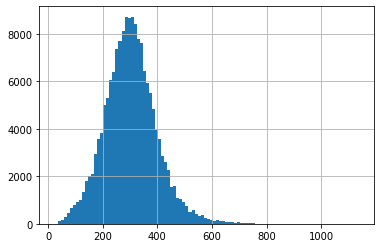

In [ ]:
df_resamples.distances.hist(bins = 100)

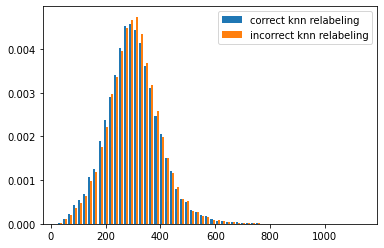

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = df_resamples[df_resamples.knn_labels == df_resamples.original_label ].distances
b = df_resamples[df_resamples.knn_labels != df_resamples.original_label ].distances

plt.hist([a, b], bins = 60, density = True, label=['correct knn relabeling', 'incorrect knn relabeling'])
plt.legend(loc='upper right')
plt.show()

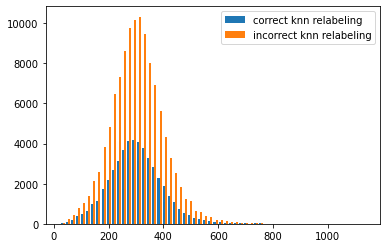

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = df_resamples[df_resamples.knn_labels == df_resamples.original_label ].distances
b = df_resamples[df_resamples.knn_labels != df_resamples.original_label ].distances

plt.hist([a, b], bins = 60, density = False, label=['correct knn relabeling', 'incorrect knn relabeling'])
plt.legend(loc='upper right')
plt.show()

In [ ]:
### Manage Distances

### Distances on correct labels spoiled

In [ ]:
def get_correct_labels_spoiled(df, tau):
  df_clean_relabeled =  df[(df.noisy_labels == df.original_label) & (df.distances < tau)]
  df_clean_missrelabeled = df_clean_relabeled[df_clean_relabeled.knn_labels != df_clean_relabeled.original_label]
  try: 
    return(round(df_clean_missrelabeled.shape[0]*100/df_clean_relabeled.shape[0],2))
  except:
    return(0)

In [ ]:
get_correct_labels_spoiled(df_resamples,2000)

69.35

In [ ]:
get_correct_labels_spoiled(df_resamples,60)

65.7

In [ ]:
corr_labels = get_correct_labels_spoiled(df_resamples,60)

In [ ]:
corr_labels_spoiled = [get_correct_labels_spoiled(df_resamples,x) for x in range(0,1000,10)]


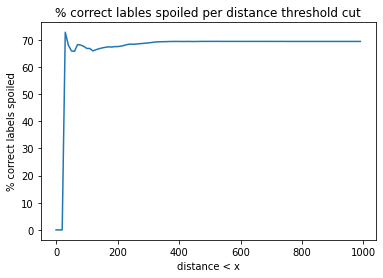

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,1000,10),corr_labels_spoiled)
plt.title('% correct lables spoiled per distance threshold cut')
plt.xlabel('distance < x')
plt.ylabel('% correct labels spoiled')
plt.show()

In [ ]:
def get_wrong_labels_corrected(df, tau):

  df_noisy_relabeled = df_resamples[(df_resamples.noisy_labels != df_resamples.original_label) & (df.distances < tau)] #filter noisy lables

  df_noisy_okrelabeled= df_noisy_relabeled[df_noisy_relabeled.knn_labels == df_noisy_relabeled.original_label]

  try: 
    return(round(df_noisy_okrelabeled.shape[0]*100/df_noisy_relabeled.shape[0],2))
  except:
    return(0)

In [ ]:
get_wrong_labels_corrected(df_resamples,2000)

18.92

In [ ]:
wrong_labels_corrected = [get_wrong_labels_corrected(df_resamples,x) for x in range(0,1000,10)]

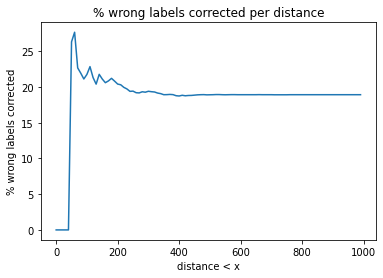

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(0,1000,10),wrong_labels_corrected)
plt.title('% wrong labels corrected per distance')
plt.xlabel('distance < x')
plt.ylabel('% wrong labels corrected')
plt.show()

In [ ]:
get_wrong_labels_corrected(df_resamples,2000)

18.92

### Correct Labels Spoiled(%)

In [ ]:
df_clean_relabeled = df_resamples[df_resamples.noisy_labels == df_resamples.original_label] #filter clean lables
df_clean_relabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,316.45460
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66,238.75777
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10,422.64935
6,cheesecake/918354.jpg,60,38,-1,501,0,60,126.03598
8,peking_duck/818947.jpg,81,4,-1,501,0,81,351.80426
...,...,...,...,...,...,...,...,...
332786,takoyaki/960118.jpg,1,59,-1,1020,9,1,232.09717
332787,spring_rolls/885046.jpg,47,47,-1,1020,9,47,295.33557
332788,sashimi/3261732.jpg,87,87,-1,1020,9,87,416.30810
332791,cup_cakes/1596178.jpg,55,55,-1,1020,9,55,392.53710


In [ ]:
df_clean = df_resamples[df_resamples.noisy_labels == df_resamples.original_label]
df_clean

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
1,creme_brulee/66315.jpg,86,86,-1,501,0,86,316.45460
2,lobster_bisque/2306644.jpg,66,66,-1,501,0,66,238.75777
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10,422.64935
6,cheesecake/918354.jpg,60,38,-1,501,0,60,126.03598
8,peking_duck/818947.jpg,81,4,-1,501,0,81,351.80426
...,...,...,...,...,...,...,...,...
332786,takoyaki/960118.jpg,1,59,-1,1020,9,1,232.09717
332787,spring_rolls/885046.jpg,47,47,-1,1020,9,47,295.33557
332788,sashimi/3261732.jpg,87,87,-1,1020,9,87,416.30810
332791,cup_cakes/1596178.jpg,55,55,-1,1020,9,55,392.53710


In [ ]:
df_clean_missrelabeled = df_clean_relabeled[df_clean_relabeled.knn_labels != df_clean_relabeled.original_label]

In [ ]:
df_clean_missrelabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
3,spaghetti_bolognese/2329553.jpg,10,33,-1,501,0,10,422.64935
6,cheesecake/918354.jpg,60,38,-1,501,0,60,126.03598
8,peking_duck/818947.jpg,81,4,-1,501,0,81,351.80426
11,bread_pudding/1315854.jpg,82,67,-1,501,0,82,510.53284
14,croque_madame/2897133.jpg,52,75,-1,501,0,52,139.96360
...,...,...,...,...,...,...,...,...
332780,scallops/1379825.jpg,19,53,-1,1020,9,19,282.87494
332784,samosa/1832423.jpg,4,47,-1,1020,9,4,328.10538
332785,cheese_plate/2817300.jpg,69,59,-1,1020,9,69,276.71020
332786,takoyaki/960118.jpg,1,59,-1,1020,9,1,232.09717


In [ ]:
round(df_clean_missrelabeled.shape[0]*100/df_clean.shape[0],2)

69.35

In [ ]:
config.r

0.1

In [ ]:
df_learning.dist[0]

'[316.4546, 238.75777, 422.64935, 126.03598, 351.80426, 139.9636, 510.53284, 139.9636, 300.2979, 236.6802, 238.75777, 220.0882, 363.6641, 556.9029, 329.29584, 294.6, 299.81494, 545.20044, 313.76385, 223.86713, 236.6802, 538.43994, 349.9361, 478.76193, 380.27765, 172.96924, 415.73996, 320.86145, 176.8552, 337.03552, 126.03598, 97.74423]'

### Wrong Labels Corrected (%)

In [ ]:
df_noisy_relabeled = df_resamples[df_resamples.noisy_labels != df_resamples.original_label] #filter noisy lables
df_noisy_relabeled

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
20,nachos/1777036.jpg,23,19,-1,501,0,28,238.75777
85,carrot_cake/1788801.jpg,38,60,-1,501,1,63,294.88187
108,french_onion_soup/1288548.jpg,21,96,-1,501,1,96,220.08820
148,nachos/1777036.jpg,23,19,-1,501,2,28,220.43008
213,carrot_cake/1788801.jpg,38,60,-1,501,3,63,236.68020
...,...,...,...,...,...,...,...,...
332717,pho/2691840.jpg,93,80,-1,1020,8,43,320.10810
332719,french_toast/3168571.jpg,80,35,-1,1020,8,77,119.11351
332735,dumplings/3057987.jpg,35,48,-1,1020,8,27,286.63522
332746,french_onion_soup/1360077.jpg,74,45,-1,1020,9,96,450.03903


In [ ]:
df_noisy = df_resamples[df_resamples.noisy_labels != df_resamples.original_label]
df_noisy

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label,distances
20,nachos/1777036.jpg,23,19,-1,501,0,28,238.75777
85,carrot_cake/1788801.jpg,38,60,-1,501,1,63,294.88187
108,french_onion_soup/1288548.jpg,21,96,-1,501,1,96,220.08820
148,nachos/1777036.jpg,23,19,-1,501,2,28,220.43008
213,carrot_cake/1788801.jpg,38,60,-1,501,3,63,236.68020
...,...,...,...,...,...,...,...,...
332717,pho/2691840.jpg,93,80,-1,1020,8,43,320.10810
332719,french_toast/3168571.jpg,80,35,-1,1020,8,77,119.11351
332735,dumplings/3057987.jpg,35,48,-1,1020,8,27,286.63522
332746,french_onion_soup/1360077.jpg,74,45,-1,1020,9,96,450.03903


In [ ]:
df_noisy_okrelabeled= df_noisy_relabeled[df_noisy_relabeled.knn_labels == df_noisy_relabeled.original_label]

In [ ]:
round(df_noisy_okrelabeled.shape[0]*100/df_noisy.shape[0],2)

18.92

In [ ]:
config.r

0.1

## Get Correct Relabelings per Image

In [ ]:
df_resamples

,dir,noisy_labels,knn_labels,knn_lresample_indexabels,batch,fast_num,original_label
1,creme_brulee/66315.jpg,86,86,-1,501,0,86
2,lobster_bisque/2306644.jpg,66,21,-1,501,0,66
3,spaghetti_bolognese/2329553.jpg,10,21,-1,501,0,10
6,cheesecake/918354.jpg,60,38,-1,501,0,60
8,peking_duck/818947.jpg,81,4,-1,501,0,81
...,...,...,...,...,...,...,...
361103,ramen/483461.jpg,64,19,-1,1065,9,64
361105,greek_salad/28044.jpg,76,19,-1,1065,9,76
361107,bruschetta/2237873.jpg,19,23,-1,1065,9,92
361108,pulled_pork_sandwich/3857080.jpg,70,19,-1,1065,9,70


In [ ]:
def correct_relabelin(original_label, knn_labels0):
  if (knn_labels == original_label):
    return(1)
  return(0)

In [ ]:
df_resamples.knn_labels = df_resamples.original_label

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
correct_resampling = df_resamples.knn_labels == df_resamples.original_label
df_resamples["correct_resampling"] = [int(x) for x in correct_resampling]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df_image_resampling_total = df_resamples[["dir", "correct_resampling"]]

In [ ]:
df_image_resampling_total = df_image_resampling_total.groupby(["dir"]).sum()
df_image_resampling_total = df_image_resampling_total.sort_values(by = "correct_resampling", ascending = False)
df_image_resampling_total

,correct_resampling
dir,
dumplings/2364896.jpg,10
bibimbap/3923684.jpg,10
club_sandwich/2517219.jpg,10
red_velvet_cake/1780416.jpg,10
pork_chop/557128.jpg,10
...,...
bread_pudding/3514583.jpg,1
onion_rings/1365366.jpg,1
tiramisu/2731942.jpg,1


In [ ]:
  filename = config.drive_dir + '/data/' + 'relabeling_'+str(int(config.r*100))+'_processed_images.csv'
  df_image_resampling_total.to_csv(filename, sep=';', index=True,header = False)

In [ ]:
filename

'/content/drive/My Drive/Colab_Notebooks/git/PFM_Noisy_Labels/FOOD101/data/relabeling_30_processed_images.csv'

In [ ]:
config.r

0.3